In [1]:
import tensorflow as tf
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import time
import h5py
import kerastuner as kt

Using TensorFlow backend.


In [2]:
### IMPORT, RAMDOMIZE AND SCALE DATA ###

def processing_data(N_channels, file_path):
    df = pd.read_csv(file_path)
    # dataset
    dataset = df.values
    # input power and channels statuses
    X = dataset[:,0:N_channels+1]
    # channel SNRs
    Y = dataset[:,N_channels+1:2*N_channels+1]
    # shuffle necessary because while shuffle=True in .fit() shuffles the data, it splits into different datasets first
    X, Y = shuffle(X, Y)
    # scaling between 0 and 1
    min_max_scaler = preprocessing.MinMaxScaler()
    X = min_max_scaler.fit_transform(X)
    Y = min_max_scaler.fit_transform(Y)
    return X, Y

In [3]:
### RECEIVE 20,000 PIECES OF DATA ###

N_channels = 40
file_path = '/Users/jackkelly/Desktop/Building_Model/Data/40_channels_data_blocks_20000.csv'
X_scale, Y_scale = processing_data(N_channels, file_path)
X_scale, X_test, Y_scale, Y_test = train_test_split(X_scale, Y_scale, test_size=0.15)

In [4]:
### FUNCTION TAKES HYPERPARAMETERS AND RETURNS COMPILED MODEL ###

def model_builder(hp):
    model = keras.Sequential()
    model.add(keras.layers.InputLayer(input_shape=N_channels+1))
#     hp_regularizer = hp.Choice('kernel_regularizer', values=[1e-4, 1e-5, 1e-6])
    for i in range(hp.Int('n_layers', 1, 2)):
#         model.add(keras.layers.Dense(hp.Int(f'hidden_{i}_units', min_value=10, max_value=320, step=1), kernel_regularizer=regularizers.l2(hp_regularizer)))
        model.add(keras.layers.Dense(hp.Int(f'hidden_{i}_units', min_value=10, max_value=320, step=1)))
    model.add(keras.layers.Dense(N_channels, activation='sigmoid'))
    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.MeanSquaredError(), metrics=['mean_squared_error'])

    return model

In [5]:
### CREATE HYPERBAND TUNER ###

# The maximum number of epochs to train one model. It is recommended to 
# set this to a value slightly higher than the expected time 
# to convergence for your largest Model, and to use early stopping 
# during training
tuner = kt.Hyperband(model_builder,
                     objective=kt.Objective('mean_squared_error', 'min'),
                     max_epochs=25,
                     factor=3,
                     directory='/Users/jackkelly/Desktop/Building_Model/',
                     project_name='intro_to_kt_layers',
                     overwrite=True)
# stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
stop_early = tf.keras.callbacks.EarlyStopping(monitor='mean_squared_error', patience=5)

In [6]:
### SEARCHING FOR THE ANN LAYOUT THAT ACCOMPLISHES THE HYPERPARAMTER GOALS ###

start_time = time.time()
# tuner.search(X_scale, Y_scale, epochs=50, validation_split=0.15, callbacks=[stop_early], verbose=2)
tuner.search(X_scale, Y_scale, validation_split=0.15, callbacks=[stop_early], verbose=2)
searching_time = time.time() - start_time
print(searching_time)

Train on 14450 samples, validate on 2550 samples
Epoch 1/3
14450/14450 - 2s - loss: 0.0067 - mean_squared_error: 0.0067 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 2/3
14450/14450 - 1s - loss: 6.3950e-04 - mean_squared_error: 6.3950e-04 - val_loss: 6.4542e-04 - val_mean_squared_error: 6.4542e-04
Epoch 3/3
14450/14450 - 1s - loss: 8.2943e-04 - mean_squared_error: 8.2943e-04 - val_loss: 7.1942e-04 - val_mean_squared_error: 7.1942e-04


Train on 14450 samples, validate on 2550 samples
Epoch 1/3
14450/14450 - 2s - loss: 0.1573 - mean_squared_error: 0.1573 - val_loss: 0.1217 - val_mean_squared_error: 0.1217
Epoch 2/3
14450/14450 - 1s - loss: 0.0912 - mean_squared_error: 0.0912 - val_loss: 0.0654 - val_mean_squared_error: 0.0654
Epoch 3/3
14450/14450 - 1s - loss: 0.0485 - mean_squared_error: 0.0485 - val_loss: 0.0352 - val_mean_squared_error: 0.0352


Train on 14450 samples, validate on 2550 samples
Epoch 1/3
14450/14450 - 2s - loss: 0.1612 - mean_squared_error: 0.1612 - val_loss: 0.1301 - val_mean_squared_error: 0.1301
Epoch 2/3
14450/14450 - 1s - loss: 0.1021 - mean_squared_error: 0.1021 - val_loss: 0.0772 - val_mean_squared_error: 0.0772
Epoch 3/3
14450/14450 - 1s - loss: 0.0595 - mean_squared_error: 0.0595 - val_loss: 0.0452 - val_mean_squared_error: 0.0452


Train on 14450 samples, validate on 2550 samples
Epoch 1/3
14450/14450 - 2s - loss: 0.1096 - mean_squared_error: 0.1096 - val_loss: 0.0955 - val_mean_squared_error: 0.0955
Epoch 2/3
14450/14450 - 1s - loss: 0.0945 - mean_squared_error: 0.0945 - val_loss: 0.0952 - val_mean_squared_error: 0.0952
Epoch 3/3
14450/14450 - 1s - loss: 0.0940 - mean_squared_error: 0.0940 - val_loss: 0.0949 - val_mean_squared_error: 0.0949


Train on 14450 samples, validate on 2550 samples
Epoch 1/3
14450/14450 - 2s - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 2/3
14450/14450 - 1s - loss: 0.0229 - mean_squared_error: 0.0229 - val_loss: 0.1155 - val_mean_squared_error: 0.1155
Epoch 3/3
14450/14450 - 1s - loss: 0.1260 - mean_squared_error: 0.1260 - val_loss: 0.1114 - val_mean_squared_error: 0.1114


Train on 14450 samples, validate on 2550 samples
Epoch 1/3
14450/14450 - 2s - loss: 0.1617 - mean_squared_error: 0.1617 - val_loss: 0.1291 - val_mean_squared_error: 0.1291
Epoch 2/3
14450/14450 - 1s - loss: 0.0997 - mean_squared_error: 0.0997 - val_loss: 0.0743 - val_mean_squared_error: 0.0743
Epoch 3/3
14450/14450 - 1s - loss: 0.0565 - mean_squared_error: 0.0565 - val_loss: 0.0424 - val_mean_squared_error: 0.0424


Train on 14450 samples, validate on 2550 samples
Epoch 1/3
14450/14450 - 2s - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 2/3
14450/14450 - 1s - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0173 - val_mean_squared_error: 0.0173
Epoch 3/3
14450/14450 - 1s - loss: 0.0945 - mean_squared_error: 0.0945 - val_loss: 0.0874 - val_mean_squared_error: 0.0874


Train on 14450 samples, validate on 2550 samples
Epoch 1/3
14450/14450 - 2s - loss: 0.1570 - mean_squared_error: 0.1570 - val_loss: 0.1185 - val_mean_squared_error: 0.1185
Epoch 2/3
14450/14450 - 1s - loss: 0.0887 - mean_squared_error: 0.0887 - val_loss: 0.0673 - val_mean_squared_error: 0.0673
Epoch 3/3
14450/14450 - 1s - loss: 0.0526 - mean_squared_error: 0.0526 - val_loss: 0.0406 - val_mean_squared_error: 0.0406


Train on 14450 samples, validate on 2550 samples
Epoch 1/3
14450/14450 - 2s - loss: 0.0786 - mean_squared_error: 0.0786 - val_loss: 0.0175 - val_mean_squared_error: 0.0175
Epoch 2/3
14450/14450 - 1s - loss: 0.0066 - mean_squared_error: 0.0066 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 3/3
14450/14450 - 1s - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 8.5192e-04 - val_mean_squared_error: 8.5192e-04


Train on 14450 samples, validate on 2550 samples
Epoch 1/3
14450/14450 - 2s - loss: 0.0706 - mean_squared_error: 0.0706 - val_loss: 0.0652 - val_mean_squared_error: 0.0652
Epoch 2/3
14450/14450 - 1s - loss: 0.0639 - mean_squared_error: 0.0639 - val_loss: 0.0652 - val_mean_squared_error: 0.0652
Epoch 3/3
14450/14450 - 1s - loss: 0.0626 - mean_squared_error: 0.0626 - val_loss: 0.0631 - val_mean_squared_error: 0.0631


Train on 14450 samples, validate on 2550 samples
Epoch 1/3
14450/14450 - 2s - loss: 0.0129 - mean_squared_error: 0.0129 - val_loss: 4.2720e-04 - val_mean_squared_error: 4.2720e-04
Epoch 2/3
14450/14450 - 1s - loss: 4.7995e-04 - mean_squared_error: 4.7996e-04 - val_loss: 3.7189e-04 - val_mean_squared_error: 3.7189e-04
Epoch 3/3
14450/14450 - 1s - loss: 4.9394e-04 - mean_squared_error: 4.9394e-04 - val_loss: 5.3620e-04 - val_mean_squared_error: 5.3620e-04


Train on 14450 samples, validate on 2550 samples
Epoch 1/3
14450/14450 - 2s - loss: 0.0064 - mean_squared_error: 0.0064 - val_loss: 9.9406e-04 - val_mean_squared_error: 9.9406e-04
Epoch 2/3
14450/14450 - 1s - loss: 7.1455e-04 - mean_squared_error: 7.1455e-04 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 3/3
14450/14450 - 1s - loss: 7.4552e-04 - mean_squared_error: 7.4552e-04 - val_loss: 0.0011 - val_mean_squared_error: 0.0011


Train on 14450 samples, validate on 2550 samples
Epoch 4/9
14450/14450 - 2s - loss: 0.0134 - mean_squared_error: 0.0134 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 5/9
14450/14450 - 1s - loss: 5.8713e-04 - mean_squared_error: 5.8713e-04 - val_loss: 4.9902e-04 - val_mean_squared_error: 4.9902e-04
Epoch 6/9
14450/14450 - 1s - loss: 5.6925e-04 - mean_squared_error: 5.6925e-04 - val_loss: 5.1198e-04 - val_mean_squared_error: 5.1198e-04
Epoch 7/9
14450/14450 - 1s - loss: 4.6006e-04 - mean_squared_error: 4.6006e-04 - val_loss: 6.0089e-04 - val_mean_squared_error: 6.0089e-04
Epoch 8/9
14450/14450 - 1s - loss: 4.8915e-04 - mean_squared_error: 4.8915e-04 - val_loss: 5.7487e-04 - val_mean_squared_error: 5.7487e-04
Epoch 9/9
14450/14450 - 1s - loss: 5.0396e-04 - mean_squared_error: 5.0396e-04 - val_loss: 4.4877e-04 - val_mean_squared_error: 4.4877e-04


Train on 14450 samples, validate on 2550 samples
Epoch 4/9
14450/14450 - 2s - loss: 0.0064 - mean_squared_error: 0.0064 - val_loss: 4.9174e-04 - val_mean_squared_error: 4.9174e-04
Epoch 5/9
14450/14450 - 1s - loss: 7.9938e-04 - mean_squared_error: 7.9938e-04 - val_loss: 4.6701e-04 - val_mean_squared_error: 4.6701e-04
Epoch 6/9
14450/14450 - 1s - loss: 7.4024e-04 - mean_squared_error: 7.4024e-04 - val_loss: 8.2953e-04 - val_mean_squared_error: 8.2953e-04
Epoch 7/9
14450/14450 - 1s - loss: 9.0957e-04 - mean_squared_error: 9.0957e-04 - val_loss: 9.9453e-04 - val_mean_squared_error: 9.9453e-04
Epoch 8/9
14450/14450 - 1s - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 9/9
14450/14450 - 1s - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0021 - val_mean_squared_error: 0.0021


Train on 14450 samples, validate on 2550 samples
Epoch 4/9
14450/14450 - 2s - loss: 0.0062 - mean_squared_error: 0.0062 - val_loss: 8.2759e-04 - val_mean_squared_error: 8.2758e-04
Epoch 5/9
14450/14450 - 1s - loss: 7.9823e-04 - mean_squared_error: 7.9823e-04 - val_loss: 7.2779e-04 - val_mean_squared_error: 7.2779e-04
Epoch 6/9
14450/14450 - 1s - loss: 8.0355e-04 - mean_squared_error: 8.0355e-04 - val_loss: 7.7343e-04 - val_mean_squared_error: 7.7343e-04
Epoch 7/9
14450/14450 - 1s - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 8/9
14450/14450 - 1s - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 9/9
14450/14450 - 1s - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0013 - val_mean_squared_error: 0.0013


Train on 14450 samples, validate on 2550 samples
Epoch 4/9
14450/14450 - 2s - loss: 0.0780 - mean_squared_error: 0.0780 - val_loss: 0.0160 - val_mean_squared_error: 0.0160
Epoch 5/9
14450/14450 - 1s - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 6/9
14450/14450 - 1s - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 8.0995e-04 - val_mean_squared_error: 8.0995e-04
Epoch 7/9
14450/14450 - 1s - loss: 6.4919e-04 - mean_squared_error: 6.4919e-04 - val_loss: 5.2398e-04 - val_mean_squared_error: 5.2398e-04
Epoch 8/9
14450/14450 - 1s - loss: 4.7268e-04 - mean_squared_error: 4.7268e-04 - val_loss: 4.7296e-04 - val_mean_squared_error: 4.7296e-04
Epoch 9/9
14450/14450 - 1s - loss: 4.0607e-04 - mean_squared_error: 4.0607e-04 - val_loss: 4.3025e-04 - val_mean_squared_error: 4.3025e-04


Train on 14450 samples, validate on 2550 samples
Epoch 10/25
14450/14450 - 2s - loss: 0.0780 - mean_squared_error: 0.0780 - val_loss: 0.0161 - val_mean_squared_error: 0.0161
Epoch 11/25
14450/14450 - 1s - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 12/25
14450/14450 - 1s - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 8.0781e-04 - val_mean_squared_error: 8.0781e-04
Epoch 13/25
14450/14450 - 1s - loss: 6.4802e-04 - mean_squared_error: 6.4802e-04 - val_loss: 5.2295e-04 - val_mean_squared_error: 5.2295e-04
Epoch 14/25
14450/14450 - 1s - loss: 4.7502e-04 - mean_squared_error: 4.7502e-04 - val_loss: 4.2933e-04 - val_mean_squared_error: 4.2933e-04
Epoch 15/25
14450/14450 - 1s - loss: 4.0694e-04 - mean_squared_error: 4.0694e-04 - val_loss: 3.6440e-04 - val_mean_squared_error: 3.6440e-04
Epoch 16/25
14450/14450 - 1s - loss: 3.6515e-04 - mean_squared_error: 3.6515e-04 - val_loss: 4.0452e-04 - val_mean_squared_error: 4.0452e-04
Epoc

Train on 14450 samples, validate on 2550 samples
Epoch 10/25
14450/14450 - 2s - loss: 0.0134 - mean_squared_error: 0.0134 - val_loss: 4.2928e-04 - val_mean_squared_error: 4.2928e-04
Epoch 11/25
14450/14450 - 1s - loss: 4.4703e-04 - mean_squared_error: 4.4703e-04 - val_loss: 3.7377e-04 - val_mean_squared_error: 3.7377e-04
Epoch 12/25
14450/14450 - 1s - loss: 5.1657e-04 - mean_squared_error: 5.1657e-04 - val_loss: 3.6397e-04 - val_mean_squared_error: 3.6397e-04
Epoch 13/25
14450/14450 - 1s - loss: 4.6057e-04 - mean_squared_error: 4.6057e-04 - val_loss: 7.3149e-04 - val_mean_squared_error: 7.3149e-04
Epoch 14/25
14450/14450 - 1s - loss: 4.8095e-04 - mean_squared_error: 4.8095e-04 - val_loss: 3.5813e-04 - val_mean_squared_error: 3.5813e-04
Epoch 15/25
14450/14450 - 1s - loss: 4.7700e-04 - mean_squared_error: 4.7700e-04 - val_loss: 5.1949e-04 - val_mean_squared_error: 5.1949e-04
Epoch 16/25
14450/14450 - 1s - loss: 5.4877e-04 - mean_squared_error: 5.4877e-04 - val_loss: 5.1915e-04 - val_mea

Train on 14450 samples, validate on 2550 samples
Epoch 1/9
14450/14450 - 2s - loss: 0.1585 - mean_squared_error: 0.1585 - val_loss: 0.1226 - val_mean_squared_error: 0.1226
Epoch 2/9
14450/14450 - 1s - loss: 0.0913 - mean_squared_error: 0.0913 - val_loss: 0.0647 - val_mean_squared_error: 0.0647
Epoch 3/9
14450/14450 - 1s - loss: 0.0476 - mean_squared_error: 0.0476 - val_loss: 0.0342 - val_mean_squared_error: 0.0342
Epoch 4/9
14450/14450 - 1s - loss: 0.0253 - mean_squared_error: 0.0253 - val_loss: 0.0183 - val_mean_squared_error: 0.0183
Epoch 5/9
14450/14450 - 1s - loss: 0.0136 - mean_squared_error: 0.0136 - val_loss: 0.0099 - val_mean_squared_error: 0.0099
Epoch 6/9
14450/14450 - 1s - loss: 0.0075 - mean_squared_error: 0.0075 - val_loss: 0.0056 - val_mean_squared_error: 0.0056
Epoch 7/9
14450/14450 - 1s - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 8/9
14450/14450 - 1s - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0022 

Train on 14450 samples, validate on 2550 samples
Epoch 1/9
14450/14450 - 2s - loss: 0.0237 - mean_squared_error: 0.0237 - val_loss: 5.8182e-04 - val_mean_squared_error: 5.8182e-04
Epoch 2/9
14450/14450 - 1s - loss: 4.6918e-04 - mean_squared_error: 4.6918e-04 - val_loss: 4.0331e-04 - val_mean_squared_error: 4.0331e-04
Epoch 3/9
14450/14450 - 2s - loss: 4.4394e-04 - mean_squared_error: 4.4394e-04 - val_loss: 4.9585e-04 - val_mean_squared_error: 4.9585e-04
Epoch 4/9
14450/14450 - 1s - loss: 4.0626e-04 - mean_squared_error: 4.0626e-04 - val_loss: 3.3649e-04 - val_mean_squared_error: 3.3649e-04
Epoch 5/9
14450/14450 - 1s - loss: 4.0247e-04 - mean_squared_error: 4.0247e-04 - val_loss: 3.5090e-04 - val_mean_squared_error: 3.5090e-04
Epoch 6/9
14450/14450 - 1s - loss: 3.7218e-04 - mean_squared_error: 3.7218e-04 - val_loss: 3.1480e-04 - val_mean_squared_error: 3.1480e-04
Epoch 7/9
14450/14450 - 1s - loss: 3.9968e-04 - mean_squared_error: 3.9968e-04 - val_loss: 3.6819e-04 - val_mean_squared_erro

Train on 14450 samples, validate on 2550 samples
Epoch 1/9
14450/14450 - 2s - loss: 0.0671 - mean_squared_error: 0.0671 - val_loss: 0.0090 - val_mean_squared_error: 0.0090
Epoch 2/9
14450/14450 - 1s - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 3/9
14450/14450 - 1s - loss: 9.2674e-04 - mean_squared_error: 9.2674e-04 - val_loss: 6.7006e-04 - val_mean_squared_error: 6.7006e-04
Epoch 4/9
14450/14450 - 1s - loss: 5.5183e-04 - mean_squared_error: 5.5183e-04 - val_loss: 4.5579e-04 - val_mean_squared_error: 4.5579e-04
Epoch 5/9
14450/14450 - 1s - loss: 4.2699e-04 - mean_squared_error: 4.2699e-04 - val_loss: 3.7986e-04 - val_mean_squared_error: 3.7986e-04
Epoch 6/9
14450/14450 - 1s - loss: 3.7980e-04 - mean_squared_error: 3.7980e-04 - val_loss: 3.5746e-04 - val_mean_squared_error: 3.5746e-04
Epoch 7/9
14450/14450 - 1s - loss: 3.5824e-04 - mean_squared_error: 3.5824e-04 - val_loss: 3.6552e-04 - val_mean_squared_error: 3.6552e-04
Epoch 8/9


Train on 14450 samples, validate on 2550 samples
Epoch 1/9
14450/14450 - 2s - loss: 0.0455 - mean_squared_error: 0.0455 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 2/9
14450/14450 - 1s - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 7.4332e-04 - val_mean_squared_error: 7.4332e-04
Epoch 3/9
14450/14450 - 1s - loss: 5.8463e-04 - mean_squared_error: 5.8463e-04 - val_loss: 4.5757e-04 - val_mean_squared_error: 4.5757e-04
Epoch 4/9
14450/14450 - 1s - loss: 4.2521e-04 - mean_squared_error: 4.2521e-04 - val_loss: 4.1360e-04 - val_mean_squared_error: 4.1360e-04
Epoch 5/9
14450/14450 - 1s - loss: 3.8541e-04 - mean_squared_error: 3.8541e-04 - val_loss: 3.3296e-04 - val_mean_squared_error: 3.3296e-04
Epoch 6/9
14450/14450 - 1s - loss: 3.6617e-04 - mean_squared_error: 3.6617e-04 - val_loss: 3.3122e-04 - val_mean_squared_error: 3.3122e-04
Epoch 7/9
14450/14450 - 1s - loss: 3.5683e-04 - mean_squared_error: 3.5683e-04 - val_loss: 3.1416e-04 - val_mean_squared_error: 3.1416e-04
Ep

Train on 14450 samples, validate on 2550 samples
Epoch 1/9
14450/14450 - 2s - loss: 0.1852 - mean_squared_error: 0.1852 - val_loss: 0.1669 - val_mean_squared_error: 0.1669
Epoch 2/9
14450/14450 - 1s - loss: 0.1511 - mean_squared_error: 0.1511 - val_loss: 0.1364 - val_mean_squared_error: 0.1364
Epoch 3/9
14450/14450 - 1s - loss: 0.1210 - mean_squared_error: 0.1210 - val_loss: 0.1072 - val_mean_squared_error: 0.1072
Epoch 4/9
14450/14450 - 1s - loss: 0.0944 - mean_squared_error: 0.0944 - val_loss: 0.0835 - val_mean_squared_error: 0.0835
Epoch 5/9
14450/14450 - 1s - loss: 0.0741 - mean_squared_error: 0.0741 - val_loss: 0.0661 - val_mean_squared_error: 0.0661
Epoch 6/9
14450/14450 - 1s - loss: 0.0589 - mean_squared_error: 0.0589 - val_loss: 0.0525 - val_mean_squared_error: 0.0525
Epoch 7/9
14450/14450 - 1s - loss: 0.0466 - mean_squared_error: 0.0466 - val_loss: 0.0412 - val_mean_squared_error: 0.0412
Epoch 8/9
14450/14450 - 1s - loss: 0.0362 - mean_squared_error: 0.0362 - val_loss: 0.0317 

Train on 14450 samples, validate on 2550 samples
Epoch 1/9
14450/14450 - 2s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 2/9
14450/14450 - 1s - loss: 5.4886e-04 - mean_squared_error: 5.4886e-04 - val_loss: 4.7794e-04 - val_mean_squared_error: 4.7794e-04
Epoch 3/9
14450/14450 - 1s - loss: 5.8700e-04 - mean_squared_error: 5.8700e-04 - val_loss: 7.6205e-04 - val_mean_squared_error: 7.6205e-04
Epoch 4/9
14450/14450 - 1s - loss: 4.5402e-04 - mean_squared_error: 4.5402e-04 - val_loss: 3.8365e-04 - val_mean_squared_error: 3.8365e-04
Epoch 5/9
14450/14450 - 1s - loss: 5.1174e-04 - mean_squared_error: 5.1174e-04 - val_loss: 4.4181e-04 - val_mean_squared_error: 4.4181e-04
Epoch 6/9
14450/14450 - 1s - loss: 5.5143e-04 - mean_squared_error: 5.5143e-04 - val_loss: 4.3831e-04 - val_mean_squared_error: 4.3831e-04
Epoch 7/9
14450/14450 - 1s - loss: 6.0995e-04 - mean_squared_error: 6.0995e-04 - val_loss: 5.6064e-04 - val_mean_squared_error: 5.606

Train on 14450 samples, validate on 2550 samples
Epoch 10/25
14450/14450 - 2s - loss: 0.0660 - mean_squared_error: 0.0660 - val_loss: 0.0088 - val_mean_squared_error: 0.0088
Epoch 11/25
14450/14450 - 1s - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 12/25
14450/14450 - 1s - loss: 9.2013e-04 - mean_squared_error: 9.2013e-04 - val_loss: 6.4177e-04 - val_mean_squared_error: 6.4177e-04
Epoch 13/25
14450/14450 - 1s - loss: 5.4732e-04 - mean_squared_error: 5.4732e-04 - val_loss: 4.5239e-04 - val_mean_squared_error: 4.5239e-04
Epoch 14/25
14450/14450 - 1s - loss: 4.2810e-04 - mean_squared_error: 4.2810e-04 - val_loss: 3.8138e-04 - val_mean_squared_error: 3.8138e-04
Epoch 15/25
14450/14450 - 1s - loss: 3.8531e-04 - mean_squared_error: 3.8531e-04 - val_loss: 3.4150e-04 - val_mean_squared_error: 3.4150e-04
Epoch 16/25
14450/14450 - 1s - loss: 3.5354e-04 - mean_squared_error: 3.5354e-04 - val_loss: 3.2555e-04 - val_mean_squared_error: 3.2555e

Train on 14450 samples, validate on 2550 samples
Epoch 10/25
14450/14450 - 2s - loss: 0.0447 - mean_squared_error: 0.0447 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 11/25
14450/14450 - 1s - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 7.6079e-04 - val_mean_squared_error: 7.6079e-04
Epoch 12/25
14450/14450 - 1s - loss: 5.8344e-04 - mean_squared_error: 5.8344e-04 - val_loss: 4.7681e-04 - val_mean_squared_error: 4.7680e-04
Epoch 13/25
14450/14450 - 1s - loss: 4.2641e-04 - mean_squared_error: 4.2641e-04 - val_loss: 3.6845e-04 - val_mean_squared_error: 3.6845e-04
Epoch 14/25
14450/14450 - 1s - loss: 3.7246e-04 - mean_squared_error: 3.7246e-04 - val_loss: 3.3556e-04 - val_mean_squared_error: 3.3556e-04
Epoch 15/25
14450/14450 - 1s - loss: 3.6953e-04 - mean_squared_error: 3.6953e-04 - val_loss: 3.2028e-04 - val_mean_squared_error: 3.2028e-04
Epoch 16/25
14450/14450 - 1s - loss: 3.4966e-04 - mean_squared_error: 3.4966e-04 - val_loss: 3.4817e-04 - val_mean_squared_error:

Train on 14450 samples, validate on 2550 samples
Epoch 1/25
14450/14450 - 3s - loss: 0.1346 - mean_squared_error: 0.1346 - val_loss: 0.0799 - val_mean_squared_error: 0.0799
Epoch 2/25
14450/14450 - 2s - loss: 0.0511 - mean_squared_error: 0.0511 - val_loss: 0.0306 - val_mean_squared_error: 0.0306
Epoch 3/25
14450/14450 - 2s - loss: 0.0191 - mean_squared_error: 0.0191 - val_loss: 0.0109 - val_mean_squared_error: 0.0109
Epoch 4/25
14450/14450 - 2s - loss: 0.0069 - mean_squared_error: 0.0069 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 5/25
14450/14450 - 2s - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 6/25
14450/14450 - 2s - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 7/25
14450/14450 - 2s - loss: 9.0945e-04 - mean_squared_error: 9.0945e-04 - val_loss: 7.4354e-04 - val_mean_squared_error: 7.4354e-04
Epoch 8/25
14450/14450 - 2s - loss: 6.5474e-04 - mean_squared_error

Train on 14450 samples, validate on 2550 samples
Epoch 1/25
14450/14450 - 2s - loss: 0.0649 - mean_squared_error: 0.0649 - val_loss: 0.0221 - val_mean_squared_error: 0.0221
Epoch 2/25
14450/14450 - 1s - loss: 0.0192 - mean_squared_error: 0.0192 - val_loss: 0.0190 - val_mean_squared_error: 0.0190
Epoch 3/25
14450/14450 - 1s - loss: 0.0181 - mean_squared_error: 0.0181 - val_loss: 0.0186 - val_mean_squared_error: 0.0186
Epoch 4/25
14450/14450 - 1s - loss: 0.0178 - mean_squared_error: 0.0178 - val_loss: 0.0188 - val_mean_squared_error: 0.0188
Epoch 5/25
14450/14450 - 1s - loss: 0.0176 - mean_squared_error: 0.0176 - val_loss: 0.0185 - val_mean_squared_error: 0.0185
Epoch 6/25
14450/14450 - 1s - loss: 0.0174 - mean_squared_error: 0.0174 - val_loss: 0.0184 - val_mean_squared_error: 0.0184
Epoch 7/25
14450/14450 - 1s - loss: 0.0172 - mean_squared_error: 0.0172 - val_loss: 0.0185 - val_mean_squared_error: 0.0185
Epoch 8/25
14450/14450 - 1s - loss: 0.0170 - mean_squared_error: 0.0170 - val_loss:

Train on 14450 samples, validate on 2550 samples
Epoch 1/25
14450/14450 - 2s - loss: 0.1599 - mean_squared_error: 0.1599 - val_loss: 0.1267 - val_mean_squared_error: 0.1267
Epoch 2/25
14450/14450 - 1s - loss: 0.0967 - mean_squared_error: 0.0967 - val_loss: 0.0709 - val_mean_squared_error: 0.0709
Epoch 3/25
14450/14450 - 1s - loss: 0.0532 - mean_squared_error: 0.0532 - val_loss: 0.0392 - val_mean_squared_error: 0.0392
Epoch 4/25
14450/14450 - 1s - loss: 0.0295 - mean_squared_error: 0.0295 - val_loss: 0.0218 - val_mean_squared_error: 0.0218
Epoch 5/25
14450/14450 - 1s - loss: 0.0163 - mean_squared_error: 0.0163 - val_loss: 0.0121 - val_mean_squared_error: 0.0121
Epoch 6/25
14450/14450 - 1s - loss: 0.0092 - mean_squared_error: 0.0092 - val_loss: 0.0069 - val_mean_squared_error: 0.0069
Epoch 7/25
14450/14450 - 1s - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 8/25
14450/14450 - 1s - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss:

Train on 14450 samples, validate on 2550 samples
Epoch 1/25
14450/14450 - 2s - loss: 0.0263 - mean_squared_error: 0.0263 - val_loss: 6.6765e-04 - val_mean_squared_error: 6.6765e-04
Epoch 2/25
14450/14450 - 2s - loss: 4.9274e-04 - mean_squared_error: 4.9274e-04 - val_loss: 3.7091e-04 - val_mean_squared_error: 3.7091e-04
Epoch 3/25
14450/14450 - 2s - loss: 3.8431e-04 - mean_squared_error: 3.8431e-04 - val_loss: 3.3659e-04 - val_mean_squared_error: 3.3659e-04
Epoch 4/25
14450/14450 - 1s - loss: 3.9038e-04 - mean_squared_error: 3.9038e-04 - val_loss: 3.6652e-04 - val_mean_squared_error: 3.6652e-04
Epoch 5/25
14450/14450 - 2s - loss: 3.9435e-04 - mean_squared_error: 3.9435e-04 - val_loss: 3.7731e-04 - val_mean_squared_error: 3.7731e-04
Epoch 6/25
14450/14450 - 2s - loss: 3.7222e-04 - mean_squared_error: 3.7222e-04 - val_loss: 3.9427e-04 - val_mean_squared_error: 3.9427e-04
Epoch 7/25
14450/14450 - 2s - loss: 3.8353e-04 - mean_squared_error: 3.8353e-04 - val_loss: 3.4596e-04 - val_mean_squar

INFO:tensorflow:Oracle triggered exit
355.216500043869


In [7]:
# Build the model with the optimal hyperparameters and train it on the data for 25 epochs
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The hyperparameter search is complete. The optimal number of hidden layers are {best_hps.get('n_layers')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_scale, Y_scale, epochs=40, shuffle=True, validation_split=0.25, verbose=0)

mean_squared_error_per_epoch = history.history['mean_squared_error']
best_epoch = mean_squared_error_per_epoch.index(min(mean_squared_error_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel_hist = hypermodel.fit(X_scale, Y_scale, epochs=best_epoch, shuffle=True, validation_split=0.15, verbose=2)


The hyperparameter search is complete. The optimal number of hidden layers are 2 and the optimal learning rate for the optimizer
is 0.0001.

Best epoch: 36
Train on 14450 samples, validate on 2550 samples
Epoch 1/36
14450/14450 - 2s - loss: 0.1308 - mean_squared_error: 0.1308 - val_loss: 0.0792 - val_mean_squared_error: 0.0792
Epoch 2/36
14450/14450 - 1s - loss: 0.0516 - mean_squared_error: 0.0516 - val_loss: 0.0316 - val_mean_squared_error: 0.0316
Epoch 3/36
14450/14450 - 1s - loss: 0.0196 - mean_squared_error: 0.0196 - val_loss: 0.0114 - val_mean_squared_error: 0.0114
Epoch 4/36
14450/14450 - 1s - loss: 0.0071 - mean_squared_error: 0.0071 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 5/36
14450/14450 - 2s - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 6/36
14450/14450 - 2s - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 7/36
14450/14450 - 1s - loss: 9.3026e-04 - m

In [8]:
# file_path = '/Users/jackkelly/Desktop/Building_Model/Data/40_channels_data_10000.csv'
# X_test, Y_test = processing_data(N_channels, file_path)
eval_result = hypermodel.evaluate(X_test, Y_test)[1]
print(eval_result)

3000/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

 - 0s 48us/sample - loss: 2.3687e-04 - mean_squared_error: 2.9921e-04
0.0002992148


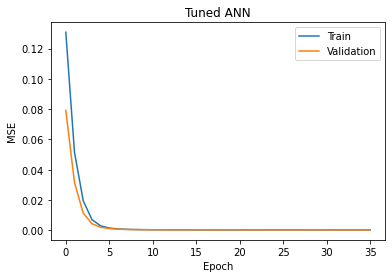

In [9]:
def visualising_data(hist, name):
    plt.title('Tuned ANN')
    plt.plot(hist.history['mean_squared_error'], label='Train')
    plt.plot(hist.history['val_mean_squared_error'], label='Validation')
    plt.ylabel('MSE')
    plt.xlabel('Epoch')
    plt.legend()
    plt.savefig(name)
    plt.show()
visualising_data(hypermodel_hist, '/Users/jackkelly/Desktop/Building_Model/Figures/hypermodel_results.png')

In [10]:
# shows weights of the ANN
# hypermodel.weights
hypermodel.summary()
# print(hypermodel.metrics_names)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 113)               4746      
_________________________________________________________________
dense_1 (Dense)              (None, 307)               34998     
_________________________________________________________________
dense_2 (Dense)              (None, 40)                12320     
Total params: 52,064
Trainable params: 52,064
Non-trainable params: 0
_________________________________________________________________


In [11]:
# INSERT SOMETHING THAT CALCUALTES ALL MEAN SQUARED ERRORS AND PLOTS ON CDF GRAPH

In [12]:
# best_hps.__dict__.keys()
# best_hps.__dict__['values']
hypermodel.save('/Users/jackkelly/Desktop/Building_Model/Tuned_' + str(N_channels) + '_channels_ANN_model_v2.h5')

# Transfer Learning

In [13]:
def transfer_learning(model_path):
    hypermodel = keras.models.load_model(model_path)
    hypermodel.summary()
    model = tf.keras.Sequential()
    for layer in hypermodel.layers[:-1]: # go through until last layer
        layer.trainable=False
        model.add(layer)
    model.add(keras.layers.Dense(40, activation='sigmoid'))
    model.summary()

    model.compile(optimizer='adam', loss=keras.losses.MeanSquaredError(), metrics=['mean_squared_error'])
    return model

In [14]:
model = transfer_learning('Tuned_' + str(N_channels) + '_channels_ANN_model_v2.h5')
N_channels = 40
file_path = '/Users/jackkelly/Desktop/Building_Model/Data/40_channels_data_variedlengths_10000.csv'
X_scale, Y_scale = processing_data(N_channels, file_path)
X_train, X_val_and_test, Y_train, Y_val_and_test = train_test_split(X_scale, Y_scale, test_size=0.3)
X_val, X_test, Y_val, Y_test = train_test_split(X_val_and_test, Y_val_and_test, test_size=0.5)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 113)               4746      
_________________________________________________________________
dense_1 (Dense)              (None, 307)               34998     
_________________________________________________________________
dense_2 (Dense)              (None, 40)                12320     
Total params: 52,064
Trainable params: 52,064
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 113)               4746      
_________________________________________________________________
dense_1 (Dense)              (None, 307)               34998     
______________________________

In [15]:
start_time = time.time()
# new_hist = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=40, shuffle=True, verbose=1, batch_size=N_channels+1)
new_hist = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=40, shuffle=True, verbose=1)
training_time = time.time() - start_time
print(training_time)

Train on 7000 samples, validate on 1500 samples
Epoch 1/40
7000/7000 [==============================] - ETA: 1:39 - loss: 0.2439 - mean_squared_error: 0.24 - ETA: 4s - loss: 0.1846 - mean_squared_error: 0.1846 - ETA: 2s - loss: 0.1561 - mean_squared_error: 0.15 - ETA: 1s - loss: 0.1329 - mean_squared_error: 0.13 - ETA: 1s - loss: 0.1148 - mean_squared_error: 0.11 - ETA: 0s - loss: 0.0990 - mean_squared_error: 0.09 - ETA: 0s - loss: 0.0878 - mean_squared_error: 0.08 - ETA: 0s - loss: 0.0785 - mean_squared_error: 0.07 - ETA: 0s - loss: 0.0708 - mean_squared_error: 0.07 - ETA: 0s - loss: 0.0644 - mean_squared_error: 0.06 - ETA: 0s - loss: 0.0603 - mean_squared_error: 0.06 - ETA: 0s - loss: 0.0555 - mean_squared_error: 0.05 - 1s 187us/sample - loss: 0.0551 - mean_squared_error: 0.0551 - val_loss: 0.0079 - val_mean_squared_error: 0.0079
Epoch 2/40
7000/7000 [==============================] - ETA: 0s - loss: 0.0077 - mean_squared_error: 0.00 - ETA: 0s - loss: 0.0070 - mean_squared_error: 0.0

7000/7000 [==============================] - ETA: 1s - loss: 9.8007e-05 - mean_squared_error: 9.8007e- - ETA: 0s - loss: 2.4023e-04 - mean_squared_error: 2.4023e- - ETA: 0s - loss: 2.4580e-04 - mean_squared_error: 2.4580e- - ETA: 0s - loss: 2.5646e-04 - mean_squared_error: 2.5646e- - ETA: 0s - loss: 2.4299e-04 - mean_squared_error: 2.4299e- - ETA: 0s - loss: 2.3355e-04 - mean_squared_error: 2.3355e- - ETA: 0s - loss: 2.3693e-04 - mean_squared_error: 2.3693e- - ETA: 0s - loss: 2.3490e-04 - mean_squared_error: 2.3490e- - ETA: 0s - loss: 2.3550e-04 - mean_squared_error: 2.3550e- - ETA: 0s - loss: 2.3524e-04 - mean_squared_error: 2.3524e- - ETA: 0s - loss: 2.3581e-04 - mean_squared_error: 2.3581e- - ETA: 0s - loss: 2.3602e-04 - mean_squared_error: 2.3602e- - 1s 108us/sample - loss: 2.3434e-04 - mean_squared_error: 2.3434e-04 - val_loss: 2.2671e-04 - val_mean_squared_error: 2.2671e-04
Epoch 11/40
7000/7000 [==============================] - ETA: 1s - loss: 2.6257e-04 - mean_squared_error: 2

Epoch 19/40
7000/7000 [==============================] - ETA: 0s - loss: 1.2597e-04 - mean_squared_error: 1.2597e- - ETA: 0s - loss: 1.2969e-04 - mean_squared_error: 1.2969e- - ETA: 0s - loss: 1.2385e-04 - mean_squared_error: 1.2385e- - ETA: 0s - loss: 1.2112e-04 - mean_squared_error: 1.2112e- - ETA: 0s - loss: 1.2323e-04 - mean_squared_error: 1.2323e- - ETA: 0s - loss: 1.2356e-04 - mean_squared_error: 1.2356e- - ETA: 0s - loss: 1.2282e-04 - mean_squared_error: 1.2282e- - ETA: 0s - loss: 1.2454e-04 - mean_squared_error: 1.2454e- - ETA: 0s - loss: 1.2425e-04 - mean_squared_error: 1.2425e- - ETA: 0s - loss: 1.2605e-04 - mean_squared_error: 1.2605e- - ETA: 0s - loss: 1.2838e-04 - mean_squared_error: 1.2838e- - 1s 96us/sample - loss: 1.2803e-04 - mean_squared_error: 1.2803e-04 - val_loss: 1.2759e-04 - val_mean_squared_error: 1.2759e-04
Epoch 20/40
7000/7000 [==============================] - ETA: 1s - loss: 1.3128e-04 - mean_squared_error: 1.3128e- - ETA: 0s - loss: 1.2775e-04 - mean_squar

7000/7000 [==============================] - ETA: 0s - loss: 1.2643e-04 - mean_squared_error: 1.2643e- - ETA: 0s - loss: 1.3127e-04 - mean_squared_error: 1.3127e- - ETA: 0s - loss: 1.2972e-04 - mean_squared_error: 1.2972e- - ETA: 0s - loss: 1.3095e-04 - mean_squared_error: 1.3095e- - ETA: 0s - loss: 1.3567e-04 - mean_squared_error: 1.3567e- - ETA: 0s - loss: 1.3154e-04 - mean_squared_error: 1.3154e- - ETA: 0s - loss: 1.2758e-04 - mean_squared_error: 1.2758e- - ETA: 0s - loss: 1.2615e-04 - mean_squared_error: 1.2615e- - ETA: 0s - loss: 1.2456e-04 - mean_squared_error: 1.2456e- - ETA: 0s - loss: 1.2356e-04 - mean_squared_error: 1.2356e- - ETA: 0s - loss: 1.2394e-04 - mean_squared_error: 1.2394e- - ETA: 0s - loss: 1.2481e-04 - mean_squared_error: 1.2481e- - 1s 106us/sample - loss: 1.2415e-04 - mean_squared_error: 1.2415e-04 - val_loss: 1.2235e-04 - val_mean_squared_error: 1.2235e-04
Epoch 29/40
7000/7000 [==============================] - ETA: 0s - loss: 8.9745e-05 - mean_squared_error: 8

7000/7000 [==============================] - ETA: 0s - loss: 7.2519e-05 - mean_squared_error: 7.2519e- - ETA: 0s - loss: 1.3195e-04 - mean_squared_error: 1.3195e- - ETA: 0s - loss: 1.3320e-04 - mean_squared_error: 1.3320e- - ETA: 0s - loss: 1.3049e-04 - mean_squared_error: 1.3049e- - ETA: 0s - loss: 1.2864e-04 - mean_squared_error: 1.2864e- - ETA: 0s - loss: 1.2591e-04 - mean_squared_error: 1.2591e- - ETA: 0s - loss: 1.2519e-04 - mean_squared_error: 1.2519e- - ETA: 0s - loss: 1.2493e-04 - mean_squared_error: 1.2493e- - ETA: 0s - loss: 1.2191e-04 - mean_squared_error: 1.2191e- - ETA: 0s - loss: 1.2190e-04 - mean_squared_error: 1.2190e- - ETA: 0s - loss: 1.2508e-04 - mean_squared_error: 1.2508e- - ETA: 0s - loss: 1.2604e-04 - mean_squared_error: 1.2604e- - 1s 107us/sample - loss: 1.2573e-04 - mean_squared_error: 1.2573e-04 - val_loss: 1.2288e-04 - val_mean_squared_error: 1.2288e-04
Epoch 38/40
7000/7000 [==============================] - ETA: 1s - loss: 1.1399e-04 - mean_squared_error: 1

In [16]:
# evaluating transfer-learned model
eval_result = model.evaluate(X_test, Y_test, verbose=1)
# evaluating OLD model with new data
hypermodel_result = hypermodel.evaluate(X_test, Y_test, verbose=0)
print(eval_result)
print(hypermodel_result)

1500/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

 - 0s 47us/sample - loss: 1.1556e-04 - mean_squared_error: 1.1979e-04
[0.00011978904365484293, 0.00011978903]
[0.00059679506936421, 0.00059679494]


In [17]:
# visualising_data(hypermodel_hist)
# visualising_data(model.history)

In [18]:
N_channels = 40
file_path = '/Users/jackkelly/Desktop/Building_Model/Data/40_channels_data_variedlengths_EDFAs_10000.csv'
X_scale, Y_scale = processing_data(N_channels, file_path)
X_train, X_val_and_test, Y_train, Y_val_and_test = train_test_split(X_scale, Y_scale, test_size=0.3)
X_val, X_test, Y_val, Y_test = train_test_split(X_val_and_test, Y_val_and_test, test_size=0.5)
start_time = time.time()
new_hist = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=40, shuffle=True, verbose=0, batch_size=N_channels+1)
training_time = time.time() - start_time
print(training_time)
# evaluating transfer-learned model
value_new = model.evaluate(X_test, Y_test, verbose=0)
# evaluating new model
value_old = hypermodel.evaluate(X_test, Y_test, verbose=0)
print(value_new)
print(value_old)

21.378423929214478
[0.0001301684723972964, 0.00013016848]
[0.0006420355515244107, 0.0006420355]


In [19]:
best_hps.__dict__

{'_space': {'n_layers': Int(name: "n_layers", min_value: 1, max_value: 2, step: 1, sampling: None, default: 1),
  'hidden_0_units': Int(name: "hidden_0_units", min_value: 10, max_value: 320, step: 1, sampling: None, default: 10),
  'learning_rate': Choice(name: "learning_rate", values: [0.01, 0.001, 0.0001], ordered: True, default: 0.01),
  'hidden_1_units': Int(name: "hidden_1_units", min_value: 10, max_value: 320, step: 1, sampling: None, default: 10)},
 'values': {'n_layers': 2,
  'hidden_0_units': 113,
  'learning_rate': 0.0001,
  'hidden_1_units': 307,
  'tuner/epochs': 25,
  'tuner/initial_epoch': 0,
  'tuner/bracket': 0,
  'tuner/round': 0},
 '_scopes': []}